In [1]:
pip install factor_analyzer

Note: you may need to restart the kernel to use updated packages.


In [12]:
pip install pandas pyreadstat openpyxl

Note: you may need to restart the kernel to use updated packages.


Bartlett's test: chi_square_value = 110.24548281480483, p_value = 2.1340886224167005e-07
KMO: 0.6037273317806333


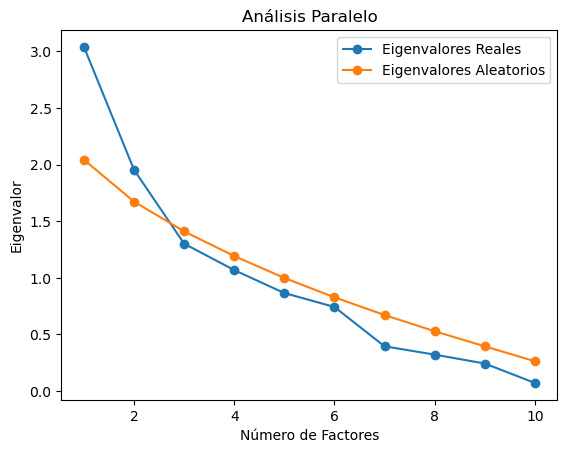

El número óptimo de factores es: 2
               0         1
Item1   0.990328  0.059253
Item2   0.781837  0.185518
Item3   0.204028  0.417501
Item4  -0.071832  0.654894
Item5   0.011327 -0.161707
Item6   0.916961  0.089473
Item7  -0.306439  0.028342
Item8   0.182847  0.548763
Item9  -0.261714  0.368835
Item10  0.088100  0.526488
El instrumento es válido en base a las cargas factoriales.
El instrumento es válido.


In [13]:
import pandas as pd
import numpy as np
from factor_analyzer import FactorAnalyzer, calculate_bartlett_sphericity, calculate_kmo
import matplotlib.pyplot as plt
import pyreadstat
import os

# Función para cargar datos desde diferentes formatos de archivo
def load_data(file_path):
    file_extension = os.path.splitext(file_path)[1].lower()
    if file_extension == '.csv':
        df = pd.read_csv(file_path)
    elif file_extension == '.xlsx' or file_extension == '.xls':
        df = pd.read_excel(file_path)
    elif file_extension == '.txt':
        df = pd.read_csv(file_path, delimiter='\t')
    elif file_extension == '.sav':
        df, meta = pyreadstat.read_sav(file_path)
    else:
        raise ValueError(f"Unsupported file format: {file_extension}")
    return df

# Función para calcular la prueba de esfericidad de Bartlett
def bartlett_test(df):
    chi_square_value, p_value = calculate_bartlett_sphericity(df)
    return chi_square_value, p_value

# Función para calcular el índice de adecuación muestral de KMO
def kmo_test(df):
    kmo_all, kmo_model = calculate_kmo(df)
    return kmo_all, kmo_model

# Función para realizar el análisis paralelo manual
def parallel_analysis(df, n_resamples=1000, random_state=0):
    np.random.seed(random_state)
    random_eigenvalues = []

    for _ in range(n_resamples):
        random_data = np.random.normal(size=df.shape)
        fa = FactorAnalyzer(n_factors=df.shape[1], rotation=None)
        fa.fit(random_data)
        random_eigenvalues.append(fa.get_eigenvalues()[0])

    random_eigenvalues = np.mean(random_eigenvalues, axis=0)
    return random_eigenvalues

# Función para realizar el análisis factorial exploratorio (EFA)
def perform_efa(df, n_factors):
    fa = FactorAnalyzer(n_factors=n_factors, rotation='varimax')
    fa.fit(df)
    factor_loadings = pd.DataFrame(fa.loadings_, index=df.columns)
    return factor_loadings, fa.get_eigenvalues()[0]

# Función para evaluar la validez del instrumento
def evaluate_validity(bartlett_p_value, kmo_model, factor_loadings):
    if bartlett_p_value > 0.05:
        print("La prueba de esfericidad de Bartlett no es significativa. Los datos podrían no ser adecuados para el análisis factorial.")
        return False
    if kmo_model < 0.6:
        print("El índice de adecuación muestral de KMO es bajo. Los datos podrían no ser adecuados para el análisis factorial.")
        return False

    # Evaluar cargas factoriales
    valid_factors = (factor_loadings.abs() > 0.4).sum(axis=0)
    if (valid_factors >= 3).all():
        print("El instrumento es válido en base a las cargas factoriales.")
        return True
    else:
        print("El instrumento no es válido en base a las cargas factoriales.")
        return False

# Función principal para ejecutar todo el análisis
def main(file_path):
    df = load_data(file_path)

    # Prueba de esfericidad de Bartlett
    chi_square_value, p_value = bartlett_test(df)
    print(f"Bartlett's test: chi_square_value = {chi_square_value}, p_value = {p_value}")

    # Índice de adecuación muestral de KMO
    kmo_all, kmo_model = kmo_test(df)
    print(f"KMO: {kmo_model}")

    # Análisis paralelo
    _, eigenvalues_real = perform_efa(df, df.shape[1])
    eigenvalues_random = parallel_analysis(df)

    # Graficar los eigenvalores reales y aleatorios
    plt.plot(range(1, df.shape[1] + 1), eigenvalues_real, marker='o', label='Eigenvalores Reales')
    plt.plot(range(1, df.shape[1] + 1), eigenvalues_random, marker='o', label='Eigenvalores Aleatorios')
    plt.xlabel('Número de Factores')
    plt.ylabel('Eigenvalor')
    plt.title('Análisis Paralelo')
    plt.legend()
    plt.show()

    # Determinar el número de factores
    n_factors = sum(eigenvalues_real > eigenvalues_random)
    print(f"El número óptimo de factores es: {n_factors}")

    # Realizar el EFA con el número óptimo de factores
    factor_loadings, _ = perform_efa(df, n_factors)
    print(factor_loadings)

    # Evaluar la validez del instrumento
    is_valid = evaluate_validity(p_value, kmo_model, factor_loadings)
    if is_valid:
        print("El instrumento es válido.")
    else:
        print("El instrumento no es válido.")

if __name__ == "__main__":
    # Reemplaza 'file_path' con la ruta de tu archivo
    file_path = 'data.txt'
    main(file_path)



# FASE 1

In [1]:
pip install rpy2

In [2]:
import pandas as pd
import numpy as np
from factor_analyzer import FactorAnalyzer, calculate_bartlett_sphericity, calculate_kmo
import matplotlib.pyplot as plt
import pyreadstat
import os
import json
import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri
from rpy2.robjects.packages import importr
from concurrent.futures import ThreadPoolExecutor, as_completed

# Activar la conversión automática entre pandas DataFrame y R data.frame
pandas2ri.activate()

# Importar paquetes R necesarios
lavaan = importr('lavaan')
base = importr('base')

# Función para cargar datos desde diferentes formatos de archivo
def load_data(file_path):
    file_extension = os.path.splitext(file_path)[1].lower()
    if file_extension == '.csv':
        df = pd.read_csv(file_path)
    elif file_extension == '.xlsx' or file_extension == '.xls':
        df = pd.read_excel(file_path)
    elif file_extension == '.txt':
        df = pd.read_csv(file_path, delimiter='\t')
    elif file_extension == '.sav':
        df, meta = pyreadstat.read_sav(file_path)
    elif file_extension == '.json':
        df = pd.read_json(file_path)
    elif file_extension == '.dta':
        df = pd.read_stata(file_path)
    elif file_extension == '.sas7bdat':
        df = pd.read_sas(file_path)
    elif file_extension == '.h5':
        df = pd.read_hdf(file_path)
    else:
        raise ValueError(f"Unsupported file format: {file_extension}")
    return df

# Función para manejar datos faltantes
def handle_missing_data(df):
    df.fillna(df.mean(), inplace=True)
    return df

# Función para calcular la prueba de esfericidad de Bartlett
def bartlett_test(df):
    chi_square_value, p_value = calculate_bartlett_sphericity(df)
    return chi_square_value, p_value

# Función para calcular el índice de adecuación muestral de KMO
def kmo_test(df):
    kmo_all, kmo_model = calculate_kmo(df)
    return kmo_all, kmo_model

# Función para realizar el análisis paralelo manual
def parallel_analysis(df, n_resamples=1000, random_state=0):
    np.random.seed(random_state)
    random_eigenvalues = []

    for _ in range(n_resamples):
        random_data = np.random.normal(size=df.shape)
        fa = FactorAnalyzer(n_factors=df.shape[1], rotation=None)
        fa.fit(random_data)
        random_eigenvalues.append(fa.get_eigenvalues()[0])

    random_eigenvalues = np.mean(random_eigenvalues, axis=0)
    return random_eigenvalues

# Función para realizar el análisis factorial exploratorio (EFA)
def perform_efa(df, n_factors, rotation='varimax'):
    fa = FactorAnalyzer(n_factors=n_factors, rotation=rotation)
    fa.fit(df)
    factor_loadings = pd.DataFrame(fa.loadings_, index=df.columns)
    return factor_loadings, fa.get_eigenvalues()[0]

# Función para automatizar la generación del modelo de CFA
def generate_cfa_model(factor_loadings, threshold=0.4):
    factors = {}
    for item, loadings in factor_loadings.iterrows():
        for factor, loading in loadings.items():
            if abs(loading) > threshold:
                if factor not in factors:
                    factors[factor] = []
                factors[factor].append(item)
    model = []
    for factor, items in factors.items():
        factor_name = f"F{factor+1}"
        items_str = " + ".join(items)
        model.append(f"{factor_name} =~ {items_str}")
    return "\n".join(model)

# Función para realizar CFA
def perform_cfa(df, model):
    r_df = pandas2ri.py2rpy(df)
    cfa_model = robjects.StrVector(model)
    cfa_result = lavaan.cfa(cfa_model, data=r_df)
    summary = base.summary(cfa_result, fit_measures=True)
    print(summary)

# Función para evaluar la validez del instrumento
def evaluate_validity(bartlett_p_value, kmo_model, factor_loadings):
    if bartlett_p_value > 0.05:
        print("La prueba de esfericidad de Bartlett no es significativa. Los datos podrían no ser adecuados para el análisis factorial.")
        return False
    if kmo_model < 0.6:
        print("El índice de adecuación muestral de KMO es bajo. Los datos podrían no ser adecuados para el análisis factorial.")
        return False

    valid_factors = (factor_loadings.abs() > 0.4).sum(axis=0)
    if (valid_factors >= 3).all():
        print("El instrumento es válido en base a las cargas factoriales.")
        return True
    else:
        print("El instrumento no es válido en base a las cargas factoriales.")
        return False

# Función para realizar validación cruzada
def cross_validation(df, n_factors, k=5):
    from sklearn.model_selection import KFold

    kf = KFold(n_splits=k, shuffle=True, random_state=0)
    results = []

    for train_index, test_index in kf.split(df):
        train_df, test_df = df.iloc[train_index], df.iloc[test_index]
        _, eigenvalues_real = perform_efa(train_df, n_factors)
        eigenvalues_random = parallel_analysis(train_df)

        n_factors_cv = sum(eigenvalues_real > eigenvalues_random)
        results.append(n_factors_cv)

    most_common_factors = max(set(results), key=results.count)
    print(f"El número más común de factores en validación cruzada es: {most_common_factors}")
    return most_common_factors

# Función principal para ejecutar todo el análisis
def main(file_path, rotation='varimax', n_folds=5):
    # Cargar datos
    df = load_data(file_path)
    df = handle_missing_data(df)

    # Realizar pruebas preliminares en paralelo
    with ThreadPoolExecutor() as executor:
        futures = {
            executor.submit(bartlett_test, df): "Bartlett Test",
            executor.submit(kmo_test, df): "KMO Test"
        }
        results = {}
        for future in as_completed(futures):
            test_name = futures[future]
            try:
                results[test_name] = future.result()
            except Exception as exc:
                print(f"{test_name} generated an exception: {exc}")

    chi_square_value, p_value = results.get("Bartlett Test", (None, None))
    kmo_all, kmo_model = results.get("KMO Test", (None, None))

    print(f"Bartlett's test: chi_square_value = {chi_square_value}, p_value = {p_value}")
    print(f"KMO: {kmo_model}")

    # Realizar EFA
    _, eigenvalues_real = perform_efa(df, df.shape[1])
    eigenvalues_random = parallel_analysis(df)

    # Graficar los eigenvalores reales y aleatorios
    plt.plot(range(1, df.shape[1] + 1), eigenvalues_real, marker='o', label='Eigenvalores Reales')
    plt.plot(range(1, df.shape[1] + 1), eigenvalues_random, marker='o', label='Eigenvalores Aleatorios')
    plt.xlabel('Número de Factores')
    plt.ylabel('Eigenvalor')
    plt.title('Análisis Paralelo')
    plt.legend()
    plt.show()

    # Determinar el número óptimo de factores
    n_factors = sum(eigenvalues_real > eigenvalues_random)
    print(f"El número óptimo de factores es: {n_factors}")

    # Realizar validación cruzada para determinar el número más estable de factores
    n_factors_cv = cross_validation(df, n_factors, n_folds)

    # Realizar EFA con el número óptimo de factores
    factor_loadings, _ = perform_efa(df, n_factors_cv, rotation)
    print(factor_loadings)

    # Generar y mostrar el modelo de CFA
    cfa_model = generate_cfa_model(factor_loadings)
    print(f"Generated CFA Model:\n{cfa_model}")

    # Realizar CFA
    perform_cfa(df, cfa_model)

    # Evaluar la validez del instrumento
    is_valid = evaluate_validity(p_value, kmo_model, factor_loadings)
    if is_valid:
        print("El instrumento es válido.")
    else:
        print("El instrumento no es válido.")

if __name__ == "__main__":
    file_path = 'data.txt'
    main(file_path)


: 